# 04 - Code Execution: Worker RPC Bridge

In the previous notebook, we saw how DAGs enable parallel task execution.

Now let's see how **code actually executes safely** inside each task using the Worker RPC Bridge architecture.

## Learning Objectives

After this notebook, you will:

- [ ] Understand the 3-layer Worker RPC Bridge architecture (ADR-032)
- [ ] Learn why functions can't be serialized and how RPC solves this
- [ ] See MCP tools called from isolated sandbox code
- [ ] Explore native tracing of tool calls (tool_start, tool_end events)
- [ ] Understand the security model (permissions: "none")

---

## The Problem: Functions Can't Be Serialized

When we want to execute user code in a **sandbox** (isolated worker), we face a fundamental challenge:

```typescript
// This won't work!
const mcpClients = {
  filesystem: {
    read_file: async (args) => { /* real implementation */ }
  }
};

worker.postMessage({ clients: mcpClients }); // ❌ Functions become undefined!
```

### Why?

`JSON.stringify()` **cannot serialize functions**. They simply disappear:

```typescript
JSON.stringify({ fn: () => 42 }); // '{}' - function gone!
```

So how do we give sandbox code access to MCP tools?

## The Solution: Worker RPC Bridge (ADR-032)

Instead of passing functions, we:

1. **Keep functions in Main Process** (where MCP clients live)
2. **Send tool definitions** (metadata only) to Worker
3. **Generate proxy functions** in Worker that send RPC messages
4. **Bridge executes real calls** and returns results

### The 3-Layer Architecture

```
┌─────────────────────────────────────────────────────────────────┐
│                      MAIN PROCESS                               │
│  ┌─────────────┐    ┌─────────────────┐                        │
│  │ MCP Clients │◄───│  WorkerBridge   │                        │
│  │ (real funcs)│    │  - traces[]     │                        │
│  └─────────────┘    │  - callTool()   │                        │
│                     └────────┬────────┘                        │
└──────────────────────────────┼─────────────────────────────────┘
                               │ postMessage (RPC)
┌──────────────────────────────┼─────────────────────────────────┐
│                     WORKER SANDBOX                              │
│              ┌───────────────▼────────────────┐                │
│              │  const mcp = {                 │                │
│              │    filesystem: {               │                │
│              │      read_file: (args) =>      │                │
│              │        __rpcCall("fs", args)   │  ← Proxies!    │
│              │    }                           │                │
│              │  };                            │                │
│              │                                │                │
│              │  // User code runs here        │                │
│              │  await mcp.filesystem.read_file│                │
│              └────────────────────────────────┘                │
│                   permissions: "none" 🔒                       │
└────────────────────────────────────────────────────────────────┘
```

════════════════════════════════════════════════════════════
         RPC MESSAGE FLOW
════════════════════════════════════════════════════════════



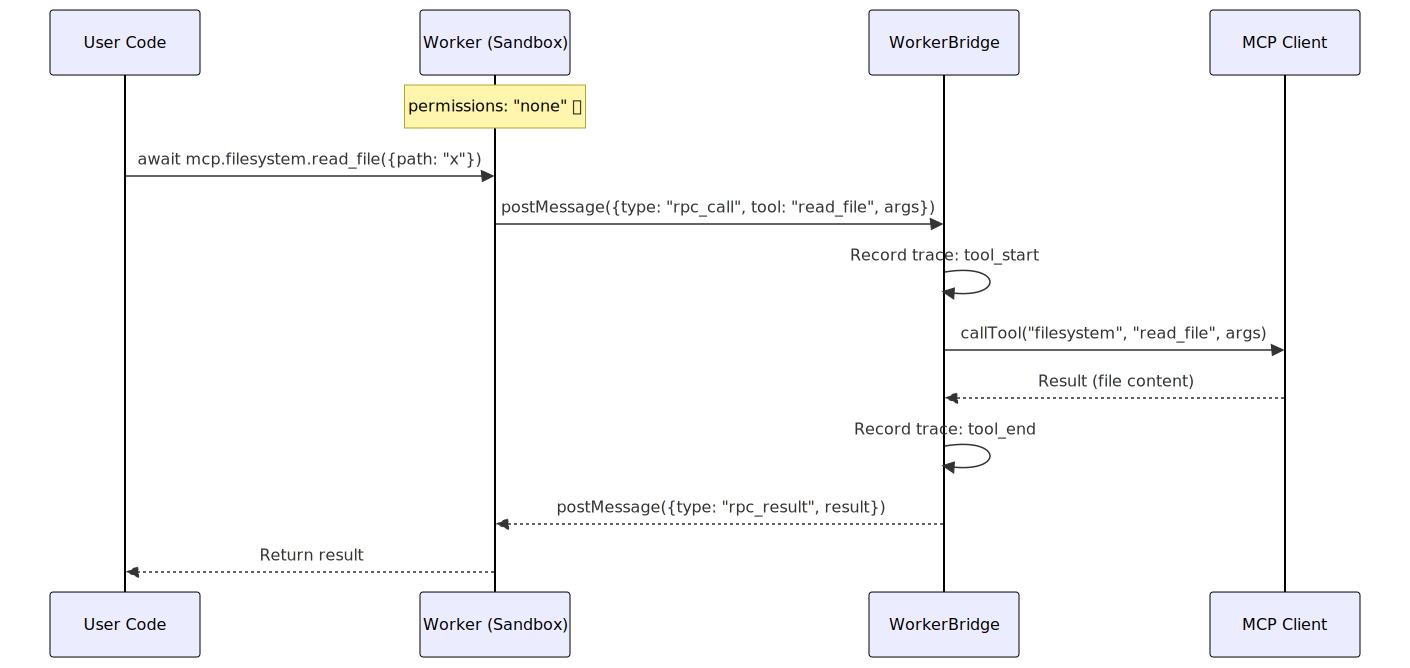

In [1]:
// Visualize the RPC message flow
import { displayMermaid } from "../lib/viz.ts";

const rpcFlowDiagram = `
sequenceDiagram
    participant U as User Code
    participant W as Worker (Sandbox)
    participant B as WorkerBridge
    participant M as MCP Client
    
    Note over W: permissions: "none" 🔒
    
    U->>W: await mcp.filesystem.read_file({path: "x"})
    W->>B: postMessage({type: "rpc_call", tool: "read_file", args})
    B->>B: Record trace: tool_start
    B->>M: callTool("filesystem", "read_file", args)
    M-->>B: Result (file content)
    B->>B: Record trace: tool_end
    B-->>W: postMessage({type: "rpc_result", result})
    W-->>U: Return result
`;

console.log("═".repeat(60));
console.log("         RPC MESSAGE FLOW");
console.log("═".repeat(60));
console.log();

await displayMermaid(rpcFlowDiagram);

## Benefits of Worker RPC Bridge

| Benefit | Description |
| ------- | ----------- |
| **MCP Tools Work** | Proxies call real MCP clients in main process |
| **Native Tracing** | Bridge captures all tool calls (no stdout parsing) |
| **Security** | Worker runs with `permissions: "none"` |
| **Structured RPC** | Type-safe message protocol |
| **Capability Learning** | Traces feed into the learning system |

---

## Live Demo: Executing Code with MCP Tools

Let's see the Worker RPC Bridge in action!

First, we'll create a **mock MCP client** for our demos (since we're in a notebook).

In [2]:
// Mock MCP Client for demonstration
// In production, this would be a real MCP server connection

interface MockFileSystem {
  [path: string]: string;
}

// Simulated file system
const mockFS: MockFileSystem = {
  "/config.json": JSON.stringify({
    version: "1.2.0",
    name: "casys-pml",
    features: ["dag-execution", "worker-rpc", "capabilities"]
  }, null, 2),
  "/users.json": JSON.stringify([
    { id: 1, name: "Alice", role: "admin" },
    { id: 2, name: "Bob", role: "user" }
  ], null, 2),
  "/readme.txt": "Welcome to Casys PML!\nThis is a demo file."
};

// In-memory entity store
const entityStore = new Map<string, unknown>();

// Mock MCP client implementing the MCPClientBase interface pattern
class MockMCPClient {
  constructor(
    public name: string,
    public tools: Map<string, (args: Record<string, unknown>) => Promise<unknown>>
  ) {}

  async callTool(toolName: string, args: Record<string, unknown>): Promise<unknown> {
    const tool = this.tools.get(toolName);
    if (!tool) {
      throw new Error(`Tool not found: ${toolName}`);
    }
    // Simulate network latency
    await new Promise(r => setTimeout(r, 50 + Math.random() * 100));
    return tool(args);
  }

  getToolDefinitions(): Array<{name: string; description: string; inputSchema: Record<string, unknown>}> {
    const defs: Array<{name: string; description: string; inputSchema: Record<string, unknown>}> = [];
    for (const [name] of this.tools) {
      defs.push({ name, description: `${name} tool`, inputSchema: {} });
    }
    return defs;
  }
}

// Create mock filesystem client
const filesystemClient = new MockMCPClient("filesystem", new Map([
  ["read_file", async (args: Record<string, unknown>) => {
    const path = args.path as string;
    const content = mockFS[path];
    if (!content) throw new Error(`File not found: ${path}`);
    return { content, path };
  }],
  ["list_directory", async (args: Record<string, unknown>) => {
    const dir = (args.path as string) || "/";
    const files = Object.keys(mockFS).filter(p => p.startsWith(dir));
    return { files, directory: dir };
  }]
]));

// Create mock memory client
const memoryClient = new MockMCPClient("memory", new Map([
  ["store_entity", async (args: Record<string, unknown>) => {
    const name = args.name as string;
    const data = args.data;
    entityStore.set(name, data);
    return { stored: true, name };
  }],
  ["get_entity", async (args: Record<string, unknown>) => {
    const name = args.name as string;
    const data = entityStore.get(name);
    if (!data) throw new Error(`Entity not found: ${name}`);
    return { name, data };
  }]
]));

// Register clients
const mcpClients = new Map<string, MockMCPClient>([
  ["filesystem", filesystemClient],
  ["memory", memoryClient]
]);

console.log("═".repeat(50));
console.log("         MOCK MCP CLIENTS READY");
console.log("═".repeat(50));
console.log();
console.log("Available clients:");
for (const [name, client] of mcpClients) {
  const tools = [...client.tools.keys()].join(", ");
  console.log(`  • ${name}: ${tools}`);
}
console.log();
console.log("Mock filesystem contents:");
for (const path of Object.keys(mockFS)) {
  console.log(`  📄 ${path}`);
}

══════════════════════════════════════════════════
         MOCK MCP CLIENTS READY
══════════════════════════════════════════════════

Available clients:
  • filesystem: read_file, list_directory
  • memory: store_entity, get_entity

Mock filesystem contents:
  📄 /config.json
  📄 /users.json
  📄 /readme.txt


## Simulating the Worker RPC Bridge

For this demo, we'll simulate the RPC bridge behavior without actually spawning a worker.

This lets us see the **tracing** and **execution flow** clearly.

In [ ]:
// Simulated Worker RPC Bridge for demonstration
// Shows the trace collection mechanism

interface TraceEvent {
  type: "tool_start" | "tool_end";
  tool: string;
  traceId: string;
  ts: number;
  success?: boolean;
  durationMs?: number;
  error?: string;
}

interface ExecutionResult {
  success: boolean;
  result?: unknown;
  error?: string;
  executionTimeMs: number;
}

class SimulatedWorkerBridge {
  private traces: TraceEvent[] = [];
  private traceIdCounter = 0;

  constructor(private clients: Map<string, MockMCPClient>) {}

  /**
   * Execute code with MCP tool access via simulated RPC
   */
  async execute(
    executor: (mcp: Record<string, Record<string, (args: Record<string, unknown>) => Promise<unknown>>>) => Promise<unknown>
  ): Promise<ExecutionResult> {
    // Reset traces AND counter for each execution (isolated execution context)
    this.traces = [];
    this.traceIdCounter = 0;
    const startTime = performance.now();

    // Build MCP proxy object (simulates what Worker receives)
    const mcp: Record<string, Record<string, (args: Record<string, unknown>) => Promise<unknown>>> = {};

    for (const [serverName, client] of this.clients) {
      mcp[serverName] = {};
      for (const [toolName] of client.tools) {
        // Create proxy that records traces and calls real tool
        mcp[serverName][toolName] = async (args: Record<string, unknown>) => {
          return this.executeToolWithTrace(serverName, toolName, args);
        };
      }
    }

    try {
      const result = await executor(mcp);
      return {
        success: true,
        result,
        executionTimeMs: performance.now() - startTime
      };
    } catch (error) {
      return {
        success: false,
        error: error instanceof Error ? error.message : String(error),
        executionTimeMs: performance.now() - startTime
      };
    }
  }

  private async executeToolWithTrace(
    server: string,
    tool: string,
    args: Record<string, unknown>
  ): Promise<unknown> {
    const traceId = `trace-${++this.traceIdCounter}`;
    const toolFullName = `${server}:${tool}`;
    const startTs = performance.now();

    // Record tool_start
    this.traces.push({
      type: "tool_start",
      tool: toolFullName,
      traceId,
      ts: startTs
    });

    try {
      const client = this.clients.get(server);
      if (!client) throw new Error(`Unknown server: ${server}`);
      
      const result = await client.callTool(tool, args);
      const endTs = performance.now();

      // Record tool_end (success)
      this.traces.push({
        type: "tool_end",
        tool: toolFullName,
        traceId,
        ts: endTs,
        success: true,
        durationMs: endTs - startTs
      });

      return result;
    } catch (error) {
      const endTs = performance.now();

      // Record tool_end (failure)
      this.traces.push({
        type: "tool_end",
        tool: toolFullName,
        traceId,
        ts: endTs,
        success: false,
        durationMs: endTs - startTs,
        error: error instanceof Error ? error.message : String(error)
      });

      throw error;
    }
  }

  getTraces(): TraceEvent[] {
    return [...this.traces];
  }
}

// Create bridge with our mock clients
const bridge = new SimulatedWorkerBridge(mcpClients);

console.log("═".repeat(50));
console.log("         WORKER BRIDGE READY");
console.log("═".repeat(50));
console.log();
console.log("Bridge initialized with", mcpClients.size, "MCP clients");
console.log("Ready to execute sandboxed code with tracing!");

---

## Demo 1: Basic Execution

Let's execute code that reads a file via MCP and see the RPC in action.

In [4]:
// Execute code that reads a file via MCP RPC

console.log("═".repeat(60));
console.log("    EXECUTING: Read file via MCP RPC");
console.log("═".repeat(60));
console.log();

const result1 = await bridge.execute(async (mcp) => {
  // This code runs in the "sandbox"
  // mcp.filesystem.read_file is a PROXY that sends RPC to bridge
  
  const file = await mcp.filesystem.read_file({ path: "/config.json" });
  return file;
});

console.log("Result:");
console.log(JSON.stringify(result1.result, null, 2));
console.log();
console.log(`Execution time: ${result1.executionTimeMs.toFixed(2)}ms`);
console.log(`Success: ${result1.success}`);

════════════════════════════════════════════════════════════
    EXECUTING: Read file via MCP RPC
════════════════════════════════════════════════════════════

Result:
{
  "content": "{\n  \"version\": \"1.2.0\",\n  \"name\": \"casys-pml\",\n  \"features\": [\n    \"dag-execution\",\n    \"worker-rpc\",\n    \"capabilities\"\n  ]\n}",
  "path": "/config.json"
}

Execution time: 138.95ms
Success: true


---

## Demo 2: Native Tracing

Every tool call is traced **natively** by the bridge - no stdout parsing needed!

Let's execute code with multiple tool calls and examine the traces.

In [5]:
// Execute code with multiple MCP tool calls

console.log("═".repeat(60));
console.log("    EXECUTING: Multiple Tool Calls");
console.log("═".repeat(60));
console.log();

const result2 = await bridge.execute(async (mcp) => {
  // 1. List directory
  const listing = await mcp.filesystem.list_directory({ path: "/" });
  
  // 2. Read config file
  const config = await mcp.filesystem.read_file({ path: "/config.json" });
  
  // 3. Store result in memory
  await mcp.memory.store_entity({ 
    name: "last_config", 
    data: JSON.parse((config as {content: string}).content)
  });
  
  return {
    filesFound: (listing as {files: string[]}).files.length,
    configVersion: JSON.parse((config as {content: string}).content).version
  };
});

console.log("Result:", JSON.stringify(result2.result, null, 2));
console.log();
console.log(`Total execution: ${result2.executionTimeMs.toFixed(2)}ms`);

════════════════════════════════════════════════════════════
    EXECUTING: Multiple Tool Calls
════════════════════════════════════════════════════════════

Result: {
  "filesFound": 3,
  "configVersion": "1.2.0"
}

Total execution: 288.48ms


In [6]:
// Display the captured traces

const traces = bridge.getTraces();

console.log("═".repeat(60));
console.log("         CAPTURED TRACES");
console.log("═".repeat(60));
console.log();

console.log("─".repeat(75));
console.log("| Type       | Tool                     | TraceID   | Duration  | Success |");
console.log("─".repeat(75));

for (const trace of traces) {
  const type = trace.type.padEnd(10);
  const tool = trace.tool.padEnd(24);
  const id = trace.traceId.padEnd(9);
  const duration = trace.durationMs ? `${trace.durationMs.toFixed(0)}ms`.padEnd(9) : "-".padEnd(9);
  const success = trace.success !== undefined ? (trace.success ? "✓" : "✗") : "-";
  
  console.log(`| ${type} | ${tool} | ${id} | ${duration} | ${success.padEnd(7)} |`);
}

console.log("─".repeat(75));
console.log();
console.log(`Total traces: ${traces.length} (${traces.filter(t => t.type === "tool_end").length} complete tool calls)`);

════════════════════════════════════════════════════════════
         CAPTURED TRACES
════════════════════════════════════════════════════════════

───────────────────────────────────────────────────────────────────────────
| Type       | Tool                     | TraceID   | Duration  | Success |
───────────────────────────────────────────────────────────────────────────
| tool_start | filesystem:list_directory | trace-2   | -         | -       |
| tool_end   | filesystem:list_directory | trace-2   | 95ms      | ✓       |
| tool_start | filesystem:read_file     | trace-3   | -         | -       |
| tool_end   | filesystem:read_file     | trace-3   | 86ms      | ✓       |
| tool_start | memory:store_entity      | trace-4   | -         | -       |
| tool_end   | memory:store_entity      | trace-4   | 106ms     | ✓       |
───────────────────────────────────────────────────────────────────────────

Total traces: 6 (3 complete tool calls)


In [ ]:
// Visualize execution timeline with Mermaid
// Note: displayMermaid already imported in cell-rpc-flow-diagram

// Build sequence diagram from traces
function tracesToSequenceDiagram(traces: TraceEvent[]): string {
  const lines: string[] = [
    "sequenceDiagram",
    "    participant C as User Code",
    "    participant B as Bridge",
    "    participant M as MCP Clients"
  ];

  for (const trace of traces) {
    if (trace.type === "tool_start") {
      const [server, tool] = trace.tool.split(":");
      lines.push(`    C->>B: ${tool}()`);
      lines.push(`    B->>M: ${server}.${tool}`);
    } else if (trace.type === "tool_end") {
      const duration = trace.durationMs?.toFixed(0) || "?";
      
      if (trace.success) {
        lines.push(`    M-->>B: ✓ (${duration}ms)`);
        lines.push(`    B-->>C: result`);
      } else {
        lines.push(`    M--xB: ✗ ${trace.error?.substring(0, 15)}`);
        lines.push(`    B--xC: throw error`);
      }
    }
  }

  return lines.join("\n");
}

console.log("═".repeat(60));
console.log("         EXECUTION TIMELINE");
console.log("═".repeat(60));
console.log();

await displayMermaid(tracesToSequenceDiagram(traces));

---

## Demo 3: Security Model

The Worker sandbox runs with `permissions: "none"`, meaning:

- ❌ No direct filesystem access (`Deno.readFile` → PermissionDenied)
- ❌ No network access (`fetch` → PermissionDenied)
- ❌ No environment access (`Deno.env` → PermissionDenied)
- ✅ MCP tools work via RPC (bridge has permissions!)

Let's demonstrate this security boundary.

In [ ]:
// Security Demo: ACTUALLY TRY forbidden operations and show real errors

console.log("═".repeat(60));
console.log("         SECURITY MODEL DEMO");
console.log("═".repeat(60));
console.log();

// Helper to safely try an operation and capture the error
async function tryForbiddenOp(name: string, op: () => Promise<unknown> | unknown): Promise<{blocked: boolean; error?: string}> {
  try {
    await op();
    return { blocked: false };
  } catch (e) {
    const msg = e instanceof Error ? e.message : String(e);
    return { blocked: true, error: msg };
  }
}

console.log("🔒 Testing REAL security boundaries...\n");

// Test 1: Direct file read (should fail with PermissionDenied)
console.log("Test 1: Deno.readFile('/etc/passwd')");
const test1 = await tryForbiddenOp("Deno.readFile", () => Deno.readFile("/etc/passwd"));
if (test1.blocked) {
  console.log(`  ❌ BLOCKED: ${test1.error}`);
} else {
  console.log("  ⚠️ ALLOWED (unexpected in sandbox!)");
}
console.log();

// Test 2: Network fetch (should fail)
console.log("Test 2: fetch('https://api.github.com')");
const test2 = await tryForbiddenOp("fetch", () => fetch("https://api.github.com"));
if (test2.blocked) {
  console.log(`  ❌ BLOCKED: ${test2.error}`);
} else {
  console.log("  ⚠️ ALLOWED (unexpected in sandbox!)");
}
console.log();

// Test 3: Environment access (should fail)
console.log("Test 3: Deno.env.get('HOME')");
const test3 = await tryForbiddenOp("Deno.env", () => Deno.env.get("HOME"));
if (test3.blocked) {
  console.log(`  ❌ BLOCKED: ${test3.error}`);
} else {
  console.log("  ⚠️ ALLOWED (unexpected in sandbox!)");
}
console.log();

// Test 4: MCP via RPC (should WORK)
console.log("Test 4: mcp.filesystem.read_file via RPC Bridge");
const test4Result = await bridge.execute(async (mcp) => {
  return await mcp.filesystem.read_file({ path: "/config.json" });
});
if (test4Result.success) {
  console.log("  ✅ ALLOWED: RPC to bridge works!");
  console.log(`     Result preview: ${JSON.stringify(test4Result.result).substring(0, 50)}...`);
} else {
  console.log(`  ❌ FAILED: ${test4Result.error}`);
}
console.log();

console.log("─".repeat(60));
console.log();
console.log("📋 SECURITY SUMMARY:");
console.log("   • Direct Deno APIs: BLOCKED (no permissions)");
console.log("   • Network/Fetch: BLOCKED (no permissions)");
console.log("   • Environment: BLOCKED (no permissions)");
console.log("   • MCP via RPC: ALLOWED (bridge has permissions)");
console.log();
console.log("Key insight: The sandbox code can ONLY interact with the");
console.log("outside world through MCP tools via the RPC bridge.");
console.log("This provides a controlled, auditable security boundary.");

In [9]:
// Demo: Error handling - what happens when a tool fails?

console.log("═".repeat(60));
console.log("    ERROR HANDLING: File Not Found");
console.log("═".repeat(60));
console.log();

const errorResult = await bridge.execute(async (mcp) => {
  // Try to read a file that doesn't exist
  const file = await mcp.filesystem.read_file({ path: "/nonexistent.txt" });
  return file;
});

console.log("Result:");
console.log(`  Success: ${errorResult.success}`);
console.log(`  Error: ${errorResult.error}`);
console.log();

// Show the error trace
const errorTraces = bridge.getTraces();
console.log("Traces (showing failure):");
for (const t of errorTraces) {
  if (t.type === "tool_end" && !t.success) {
    console.log(`  ✗ ${t.tool}: ${t.error}`);
  }
}

════════════════════════════════════════════════════════════
    ERROR HANDLING: File Not Found
════════════════════════════════════════════════════════════

Result:
  Success: false
  Error: File not found: /nonexistent.txt

Traces (showing failure):
  ✗ filesystem:read_file: File not found: /nonexistent.txt


---

## Use Case: Complete Workflow

Let's put it all together with a realistic use case:

1. Read a config file via MCP
2. Parse and extract values
3. Store processed data in memory
4. Return summary with traces

In [10]:
// Complete workflow: read → process → store

console.log("═".repeat(60));
console.log("    COMPLETE WORKFLOW: Config Processing");
console.log("═".repeat(60));
console.log();

const workflowResult = await bridge.execute(async (mcp) => {
  // Step 1: Read config.json
  console.log("Step 1: Reading config.json...");
  const configFile = await mcp.filesystem.read_file({ path: "/config.json" });
  const config = JSON.parse((configFile as {content: string}).content);
  console.log(`  → Found version: ${config.version}`);
  
  // Step 2: Read users.json
  console.log("Step 2: Reading users.json...");
  const usersFile = await mcp.filesystem.read_file({ path: "/users.json" });
  const users = JSON.parse((usersFile as {content: string}).content);
  console.log(`  → Found ${users.length} users`);
  
  // Step 3: Store processed summary
  console.log("Step 3: Storing summary in memory...");
  const summary = {
    appName: config.name,
    version: config.version,
    features: config.features,
    userCount: users.length,
    adminUsers: users.filter((u: {role: string}) => u.role === "admin").map((u: {name: string}) => u.name),
    processedAt: new Date().toISOString()
  };
  await mcp.memory.store_entity({ name: "app_summary", data: summary });
  console.log("  → Summary stored!");
  
  return summary;
});

console.log();
console.log("─".repeat(60));
console.log("RESULT:");
console.log(JSON.stringify(workflowResult.result, null, 2));
console.log();
console.log(`Total execution: ${workflowResult.executionTimeMs.toFixed(2)}ms`);

════════════════════════════════════════════════════════════
    COMPLETE WORKFLOW: Config Processing
════════════════════════════════════════════════════════════

Step 1: Reading config.json...
  → Found version: 1.2.0
Step 2: Reading users.json...
  → Found 2 users
Step 3: Storing summary in memory...
  → Summary stored!

────────────────────────────────────────────────────────────
RESULT:
{
  "appName": "casys-pml",
  "version": "1.2.0",
  "features": [
    "dag-execution",
    "worker-rpc",
    "capabilities"
  ],
  "userCount": 2,
  "adminUsers": [
    "Alice"
  ],
  "processedAt": "2025-12-15T03:45:50.627Z"
}

Total execution: 269.52ms


In [11]:
// Show complete trace analysis

const workflowTraces = bridge.getTraces();

console.log("═".repeat(60));
console.log("         WORKFLOW TRACE ANALYSIS");
console.log("═".repeat(60));
console.log();

// Calculate stats
const toolCalls = workflowTraces.filter(t => t.type === "tool_end");
const successCalls = toolCalls.filter(t => t.success);
const totalDuration = toolCalls.reduce((sum, t) => sum + (t.durationMs || 0), 0);

console.log("Summary:");
console.log(`  • Tool calls: ${toolCalls.length}`);
console.log(`  • Successful: ${successCalls.length}`);
console.log(`  • Failed: ${toolCalls.length - successCalls.length}`);
console.log(`  • Total tool time: ${totalDuration.toFixed(2)}ms`);
console.log();

console.log("Tool breakdown:");
const toolTimes = new Map<string, number>();
for (const trace of toolCalls) {
  const current = toolTimes.get(trace.tool) || 0;
  toolTimes.set(trace.tool, current + (trace.durationMs || 0));
}

for (const [tool, time] of toolTimes) {
  const pct = ((time / totalDuration) * 100).toFixed(1);
  const bar = "█".repeat(Math.round(time / 10));
  console.log(`  ${tool.padEnd(25)} ${time.toFixed(0).padStart(5)}ms ${bar} (${pct}%)`);
}

════════════════════════════════════════════════════════════
         WORKFLOW TRACE ANALYSIS
════════════════════════════════════════════════════════════

Summary:
  • Tool calls: 3
  • Successful: 3
  • Failed: 0
  • Total tool time: 268.82ms

Tool breakdown:
  filesystem:read_file        140ms ██████████████ (52.3%)
  memory:store_entity         128ms █████████████ (47.7%)


---

## 🎯 Checkpoint: Write Code Using Multiple MCP Tools

**Exercise:** Write code that:

1. Reads `/readme.txt` using `mcp.filesystem.read_file()`
2. Stores the content using `mcp.memory.store_entity()`
3. Returns the number of lines in the file

Fill in the code below:

In [12]:
// EXERCISE: Fill in the code below
// Hint: The file content is in result.content

const exerciseResult = await bridge.execute(async (mcp) => {
  // TODO: Read /readme.txt
  // const readme = await mcp.filesystem.????
  
  // TODO: Store content in memory with name "readme_backup"
  // await mcp.memory.????
  
  // TODO: Return the number of lines
  // return { lineCount: ??? };
  
  return { lineCount: 0 }; // Replace this!
});

console.log("Your result:", exerciseResult.result);
console.log();
console.log("Traces captured:", bridge.getTraces().filter(t => t.type === "tool_end").length, "tool calls");

Your result: { lineCount: 0 }

Traces captured: 0 tool calls


In [13]:
// SOLUTION (run after attempting the exercise!)

console.log("═".repeat(60));
console.log("         SOLUTION");
console.log("═".repeat(60));
console.log();

const solutionResult = await bridge.execute(async (mcp) => {
  // 1. Read /readme.txt
  const readme = await mcp.filesystem.read_file({ path: "/readme.txt" });
  const content = (readme as {content: string}).content;
  
  // 2. Store content in memory
  await mcp.memory.store_entity({ 
    name: "readme_backup", 
    data: { content, storedAt: new Date().toISOString() }
  });
  
  // 3. Count lines and return
  const lineCount = content.split("\n").length;
  return { lineCount, preview: content.substring(0, 50) + "..." };
});

console.log("Result:", JSON.stringify(solutionResult.result, null, 2));
console.log();

// Verify traces
const solutionTraces = bridge.getTraces();
const toolNames = solutionTraces
  .filter(t => t.type === "tool_end")
  .map(t => t.tool);

console.log("Verification:");
console.log(`  ✓ filesystem:read_file called: ${toolNames.includes("filesystem:read_file")}`);
console.log(`  ✓ memory:store_entity called: ${toolNames.includes("memory:store_entity")}`);
console.log(`  ✓ Both tools succeeded: ${solutionTraces.filter(t => t.type === "tool_end").every(t => t.success)}`);

════════════════════════════════════════════════════════════
         SOLUTION
════════════════════════════════════════════════════════════

Result: {
  "lineCount": 2,
  "preview": "Welcome to Casys PML!\nThis is a demo file...."
}

Verification:
  ✓ filesystem:read_file called: true
  ✓ memory:store_entity called: true
  ✓ Both tools succeeded: true


---

## Summary

### What We Learned

1. **Functions can't be serialized** - `JSON.stringify()` loses functions
2. **Worker RPC Bridge** solves this with:
   - Proxy functions that send RPC messages
   - Bridge executes real MCP calls
   - Results returned via postMessage
3. **Native tracing** captures all tool calls without stdout parsing
4. **Security model** (`permissions: "none"`) blocks direct access
5. **MCP tools work** because they use RPC to the permissioned bridge

### Key Architecture

```
User Code → Worker Proxy → postMessage → Bridge → MCP Client → Result
             (no perms)                  (has perms)
```

---

## 🔗 Why This Matters for PML

The traces captured by the Worker RPC Bridge are **the foundation of Capability Learning**.

### From Traces to Capabilities

```
┌─────────────────────────────────────────────────────────────┐
│  EXECUTION (this notebook)                                  │
│                                                             │
│  Code executes → Bridge traces tool calls → Success!        │
│                                                             │
└─────────────────────────┬───────────────────────────────────┘
                          │
                          ▼ traces saved
┌─────────────────────────────────────────────────────────────┐
│  CAPABILITY LEARNING (notebook 05)                          │
│                                                             │
│  Traces analyzed → Code hashed → Stored as Capability       │
│                                                             │
└─────────────────────────┬───────────────────────────────────┘
                          │
                          ▼ capability reused
┌─────────────────────────────────────────────────────────────┐
│  EMERGENT REUSE (notebook 06)                               │
│                                                             │
│  Similar intent → Match capability → Execute directly!      │
│  (No regeneration needed = 5x faster)                       │
│                                                             │
└─────────────────────────────────────────────────────────────┘
```

### The Key Insight

> Without **native tracing**, we couldn't learn from executions.
>
> The Worker RPC Bridge doesn't just execute code - it **observes** what works.
> This observation is what enables **procedural memory**.

In the next notebook (05), you'll see how these traces become reusable **Capabilities** - the system's muscle memory.

---

**Next:** [05-capability-learning.ipynb](./05-capability-learning.ipynb) - Learn how traces become reusable capabilities